Time Series Analysis

In [75]:
# libraries
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.formula.api as smf


# statsmodels.tsa.arima

import pmdarima as pm


## Exploration/Plots

In [2]:
# load in data
reports = gpd.read_file('modified_data/augmented_311.csv')
print(reports.head())
reports['date_requested'] = pd.to_datetime(reports['date_requested'])



  field_1 service_request_id sap_notification_number date_requested  \
0       0            3454060                             2021-08-01   
1       1            3454993                             2021-08-02   
2       2            3457547                             2021-08-04   
3       3            3456172                             2021-08-03   
4       4            3457550                             2021-08-04   

  case_age_days       case_record_type          date_closed    status  \
0            12  Neighborhood Policing  2021-08-12 00:00:00    Closed   
1             1  Neighborhood Policing  2021-08-03 00:00:00    Closed   
2            40  Neighborhood Policing  2021-09-13 00:00:00  Referred   
3            30   ESD Complaint/Report  2021-09-02 00:00:00    Closed   
4            19   ESD Complaint/Report  2021-08-23 00:00:00    Closed   

                lat           lng  ...        date time time_period week_type  \
0        32.6966108  -117.1148684  ...  2021-08-01   

In [3]:
print(reports.shape[0])

213949


In [4]:
reports.columns

Index(['field_1', 'service_request_id', 'sap_notification_number',
       'date_requested', 'case_age_days', 'case_record_type', 'date_closed',
       'status', 'lat', 'lng', 'street_address', 'zipcode', 'council_district',
       'comm_plan_code', 'comm_plan_name', 'park_name', 'case_origin',
       'referred', 'iamfloc', 'floc', 'public_description', 'Case Number',
       'Department', 'Date/Time Opened', 'Case Reason',
       'Display Referral Information', 'prop_uppercase', 'prop_all_caps',
       'num_exclamation', 'num_question', 'clean_text', 'word_count',
       'clean_text_for_sentiment', 'misspelled_words', 'num_misspelled',
       'year', 'month', 'day', 'date', 'time', 'time_period', 'week_type',
       'geometry', 'in_transit_area', 'in_park', 'in_school_area',
       'in_open_space', 'in_waterway'],
      dtype='object')

In [24]:
# drop all duplicates
reports_clean = reports.drop_duplicates(
    subset=["date_requested", "Date/Time Opened", "public_description", "street_address"]
)
reports.shape[0] - reports_clean.shape[0]  

1054

In [25]:
reports_clean

,field_1,service_request_id,sap_notification_number,date_requested,case_age_days,case_record_type,date_closed,status,lat,lng,...,time,time_period,week_type,geometry,in_transit_area,in_park,in_school_area,in_open_space,in_waterway,in_sens_area
0,0,3454060,,2021-08-01,12,Neighborhood Policing,2021-08-12 00:00:00,Closed,32.6966108,-117.1148684,...,1,Dark,Weekend,POINT (6295589.279646916 1834343.227680732),0,0,0,0,0,1
1,1,3454993,,2021-08-02,1,Neighborhood Policing,2021-08-03 00:00:00,Closed,32.7627358263844,-117.0662518,...,1,Dark,Weekday,POINT (6310734.245923505 1858281.285759502),1,0,0,0,0,1
2,2,3457547,,2021-08-04,40,Neighborhood Policing,2021-09-13 00:00:00,Referred,32.7883457662006,-117.2542375,...,1,Dark,Weekday,POINT (6253034.980425371 1868103.4531590594),1,0,0,0,0,1
3,3,3456172,,2021-08-03,30,ESD Complaint/Report,2021-09-02 00:00:00,Closed,32.7526659110063,-117.1465159,...,1,Dark,Weekday,POINT (6286028.505116988 1854820.183631435),1,0,0,0,0,1
4,4,3457550,,2021-08-04,19,ESD Complaint/Report,2021-08-23 00:00:00,Closed,32.7460031444519,-117.1599057,...,1,Dark,Weekday,POINT (6281890.694429106 1852431.7130724536),1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213942,213942,5271875,,2025-06-28,125,Neighborhood Policing,10/31/2025,Closed,32.79241218231944,-117.0462275,...,1,Dark,Weekend,POINT (6316972.457926419 1869031.0065083636),0,1,0,0,0,1
213944,213944,5261882,,2025-06-20,136,Neighborhood Policing,11/3/2025,Closed,32.706479533510205,-117.1199069,...,1,Dark,Weekday,POINT (6294069.174939836 1837946.7068753957),1,0,0,0,1,1
213946,213946,5121852,,2025-02-24,255,Neighborhood Policing,11/6/2025,Closed,32.7286713,-117.0653949,...,1,Dark,Weekday,POINT (6310900.742410863 1845885.341907829),0,0,0,0,1,1
213947,213947,5169378,,2025-04-02,218,Neighborhood Policing,11/6/2025,Closed,32.79619964702752,-117.2096772,...,1,Dark,Weekday,POINT (6266755.575511668 1870831.9638023193),0,0,0,0,1,1


In [26]:
sensitive_area_cols = ['in_transit_area', 'in_park', 'in_school_area', 'in_open_space', 'in_waterway']

reports_clean['in_sens_area'] = reports_clean[sensitive_area_cols].any(axis=1).astype(int)
reports_clean.head()

/var/folders/rz/h3gzrv2j09s6d_5vmn0bglw40000gn/T/ipykernel_24497/812558449.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reports_clean['in_sens_area'] = reports_clean[sensitive_area_cols].any(axis=1).astype(int)


,field_1,service_request_id,sap_notification_number,date_requested,case_age_days,case_record_type,date_closed,status,lat,lng,...,time,time_period,week_type,geometry,in_transit_area,in_park,in_school_area,in_open_space,in_waterway,in_sens_area
0,0,3454060,,2021-08-01,12,Neighborhood Policing,2021-08-12 00:00:00,Closed,32.6966108,-117.1148684,...,1,Dark,Weekend,POINT (6295589.279646916 1834343.227680732),0,0,0,0,0,1
1,1,3454993,,2021-08-02,1,Neighborhood Policing,2021-08-03 00:00:00,Closed,32.7627358263844,-117.0662518,...,1,Dark,Weekday,POINT (6310734.245923505 1858281.285759502),1,0,0,0,0,1
2,2,3457547,,2021-08-04,40,Neighborhood Policing,2021-09-13 00:00:00,Referred,32.7883457662006,-117.2542375,...,1,Dark,Weekday,POINT (6253034.980425371 1868103.4531590594),1,0,0,0,0,1
3,3,3456172,,2021-08-03,30,ESD Complaint/Report,2021-09-02 00:00:00,Closed,32.7526659110063,-117.1465159,...,1,Dark,Weekday,POINT (6286028.505116988 1854820.183631435),1,0,0,0,0,1
4,4,3457550,,2021-08-04,19,ESD Complaint/Report,2021-08-23 00:00:00,Closed,32.7460031444519,-117.1599057,...,1,Dark,Weekday,POINT (6281890.694429106 1852431.7130724536),1,0,0,0,0,1


In [ ]:

reports_clean['in_sens_area'].mean()

np.float64(1.0)

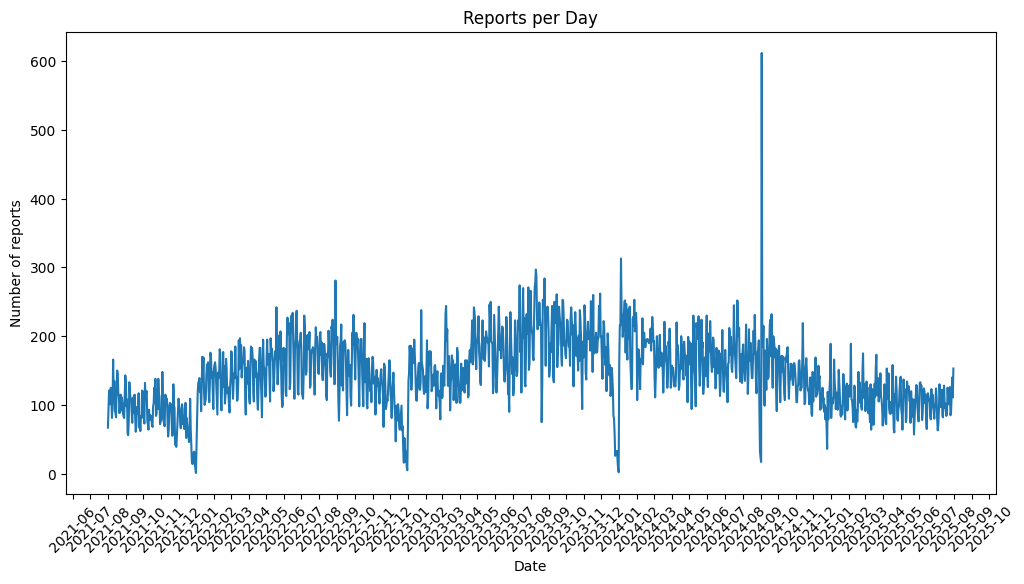

In [17]:
# plot time series (all)

report_counts = reports_clean.groupby('date_requested').size().reset_index(name='n')
report_counts.set_index("date_requested", inplace=True)
plt.figure(figsize=(12, 6))
plt.plot(report_counts['n'])
plt.xlabel("Date")
plt.ylabel("Number of reports")
plt.title("Reports per Day")

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.xticks(rotation=45)
plt.show()



Investigate the spikes...

In [45]:
spike_dates = report_counts[report_counts['n'] > 600].index
spike_dates 

DatetimeIndex(['2024-09-03'], dtype='datetime64[ns]', name='date_requested', freq=None)

In [46]:
spike_reports = reports[reports["date_requested"].isin(spike_dates)]
# check for duplicates
spike_reports[spike_reports[["date_requested", 'Date/Time Opened', "public_description", "street_address"]].duplicated()]

,field_1,service_request_id,sap_notification_number,date_requested,case_age_days,case_record_type,date_closed,status,lat,lng,...,time,time_period,week_type,geometry,in_transit_area,in_park,in_school_area,in_open_space,in_waterway,in_sens_area
173310,173310,4911905,,2024-09-03,6,Neighborhood Policing,2024-09-09 00:00:00,Closed,32.70927833,-117.1646805,...,1,Dark,Weekday,POINT (6280305.3663277775 1839082.8696498948),1,1,0,0,0,1
173327,173327,4911916,,2024-09-03,6,Neighborhood Policing,2024-09-09 00:00:00,Closed,32.70927833,-117.1646664,...,1,Dark,Weekday,POINT (6280309.703462516 1839082.8316012563),1,1,0,0,0,1
173337,173337,4910806,,2024-09-03,23,Neighborhood Policing,2024-09-26 00:00:00,Closed,32.71525284,-117.1548269,...,1,Dark,Weekday,POINT (6283355.181551444 1841230.1477381424),1,0,0,0,0,1
173347,173347,4911924,,2024-09-03,6,Neighborhood Policing,2024-09-09 00:00:00,Closed,32.70928759,-117.1646938,...,1,Dark,Weekday,POINT (6280301.304828504 1839086.2746328632),1,1,0,0,0,1
173549,173549,4912960,,2024-09-03,8,Neighborhood Policing,2024-09-11 00:00:00,Closed,32.70104374,-117.1417357,...,1,Dark,Weekday,POINT (6287337.528240112 1836025.7087725794),1,0,0,0,0,1
173606,173606,4912993,,2024-09-03,8,Neighborhood Policing,2024-09-11 00:00:00,Closed,32.70103947,-117.1417159,...,1,Dark,Weekday,POINT (6287343.605978198 1836024.1031083432),1,0,0,0,0,1
173680,173680,4911172,,2024-09-03,21,Neighborhood Policing,2024-09-24 00:00:00,Closed,32.75019854,-117.194765,...,1,Dark,Weekday,POINT (6271186.346445814 1854053.4603770135),0,0,0,0,0,1
173760,173760,4912147,,2024-09-03,7,Neighborhood Policing,2024-09-10 00:00:00,Referred,32.72003486,-117.1469499,...,1,Dark,Weekday,POINT (6285792.938793658 1842949.0718693472),0,1,0,0,0,1
213732,213732,4911220,,2024-09-03,359,ESD Abatement,8/28/2025,Closed,32.720495,-117.1631,...,1,Dark,Weekday,POINT (6280827.265307165 1843159.601741749),1,0,0,0,0,1


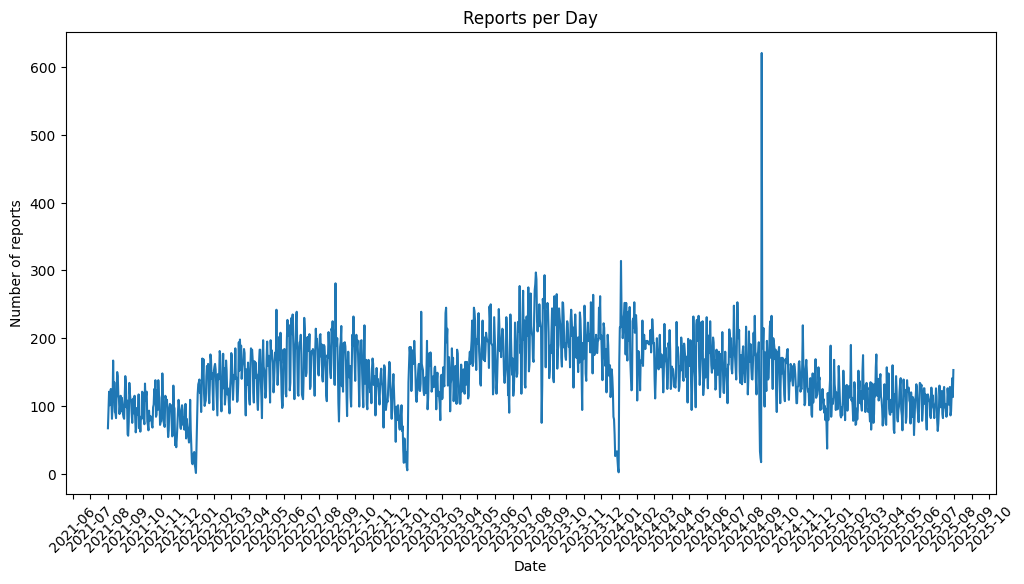

In [12]:
# plot time series (just sensitive areas) 
# makes sense that it looks very similar to the overall one
# looks like number of reports... go down after ordinance was passed?

reports_sens = reports[reports['in_sens_area']==1]
report_counts_sens = reports_sens.groupby('date_requested').size().reset_index(name='n')
report_counts_sens.set_index("date_requested", inplace=True)
plt.figure(figsize=(12, 6))
plt.plot(report_counts_sens['n'])
plt.xlabel("Date")
plt.ylabel("Number of reports")
plt.title("Reports per Day")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.xticks(rotation=45)
plt.show()

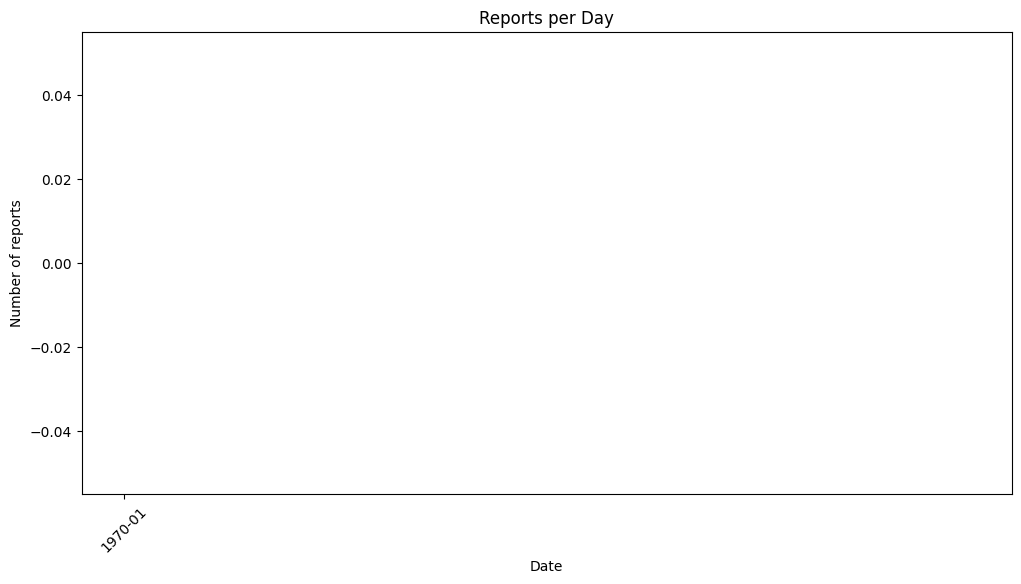

In [28]:
# plot time series (non-sensitive areas) 
# looks more stationary that the plot of sensitive areas
reports_non_sens = reports_clean[reports_clean['in_sens_area']==0]
report_counts_non_sens = reports_non_sens.groupby('date_requested').size().reset_index(name='n')
report_counts_non_sens.set_index("date_requested", inplace=True)
plt.figure(figsize=(12, 6))
plt.plot(report_counts_non_sens['n'])
plt.xlabel("Date")
plt.ylabel("Number of reports")
plt.title("Reports per Day")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.xticks(rotation=45)
plt.show()

## ACF/PACF Plots of Sensitive Areas

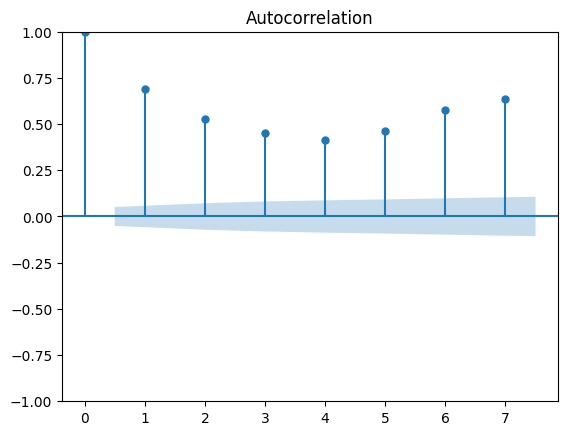

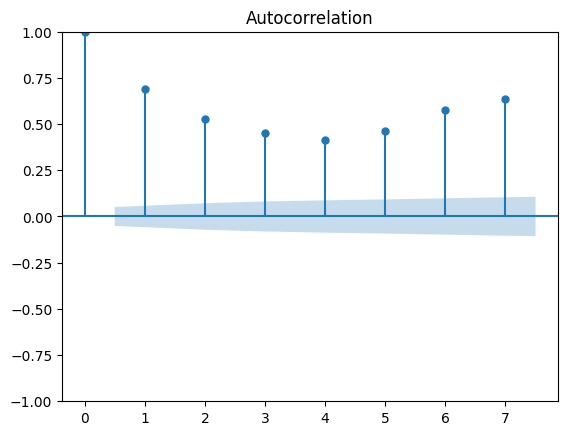

In [29]:
# weekly seasonality
plot_acf(report_counts_sens['n'], lags=7)

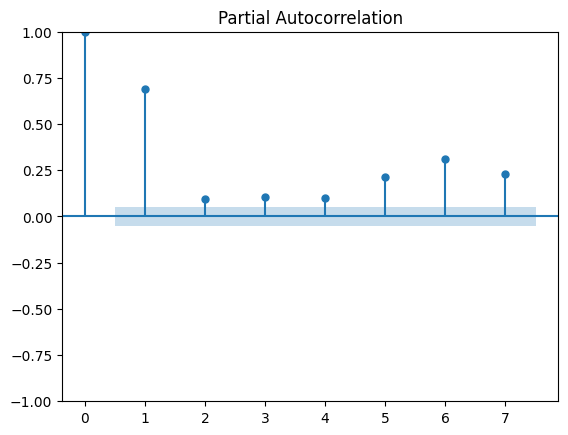

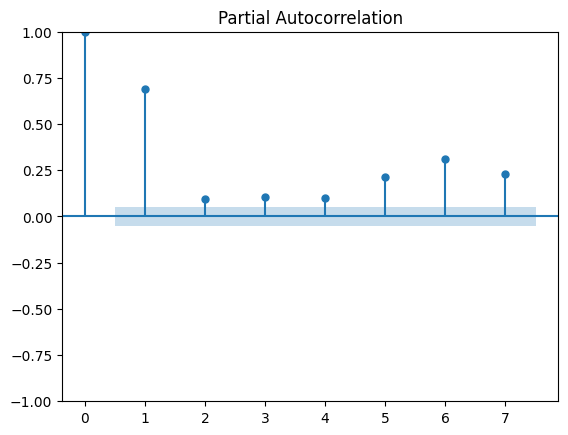

In [30]:
plot_pacf(report_counts_sens['n'], lags=7)

## Create intervention variables representing step change and change in slope (ramp)

In [31]:
ord_date = pd.to_datetime('2023-07-31')

# create step variable (binary indicator for before/after the ordinance was passed)
step = (report_counts.index >= ord_date).astype(int)
step

array([0, 0, 0, ..., 1, 1, 1], shape=(1461,))

In [32]:
# create ramp variable (measuring the slope change)
# pad the number of days in the time series before the intervention with zeroes
ramp = np.maximum(0, (report_counts.index - ord_date).days)
ramp

Index([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
       ...
       722, 723, 724, 725, 726, 727, 728, 729, 730, 731],
      dtype='int64', name='date_requested', length=1461)

## Fit SARIMA model

In [ ]:
model = pm.auto_arima(report_counts_sens, 
                             exogenous= np.column_stack([step, ramp]),
                             seasonal=True, 
                             m=7, 
                             stepwise=True)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                      y   No. Observations:                 1461
Model:             SARIMAX(1, 1, 1)x(0, 0, [1, 2], 7)   Log Likelihood               -7182.431
Date:                                Wed, 21 Jan 2026   AIC                          14374.862
Time:                                        10:07:41   BIC                          14401.293
Sample:                                    08-01-2021   HQIC                         14384.722
                                         - 07-31-2025                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4324      0.012     34.623      0.000       0.408       0.457
ma.L1         -0.9640      0.006   -163.682      0.000      -0.976      -0.952
ma.S.L7        0.2098      0.014     14.798      0.000       0.182       0.238
ma.S.L14       0.2102      0.025      8.278      0.000       0.160       0.260
sigma2      1096.2170     13.220     82.919      0.000    1070.306    1122.128
===================================================================================
Ljung-Box (L1) (Q):                   0.29   Jarque-Bera (JB):            107737.79
Prob(Q):                              0.59   Prob(JB):                         0.00
Heteroskedasticity (H):               2.05   Skew:                             2.72
Prob(H) (two-sided):                  0.00   Kurtosis:                        44.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

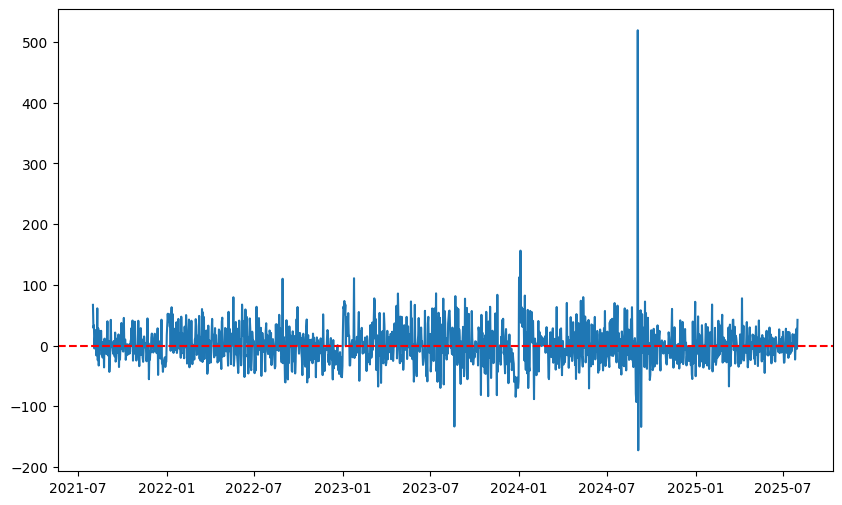

In [34]:
# check residuals
residuals = model.resid()

# plot
# we still see some heteroskedasticity 
plt.figure(figsize=(10,6))
plt.plot(residuals)
plt.axhline(0, color="red", linestyle="--")

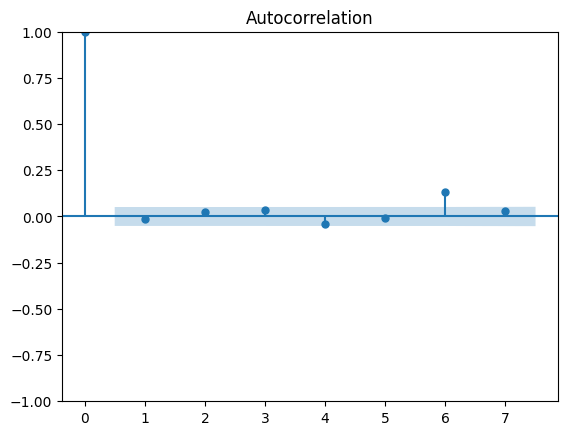

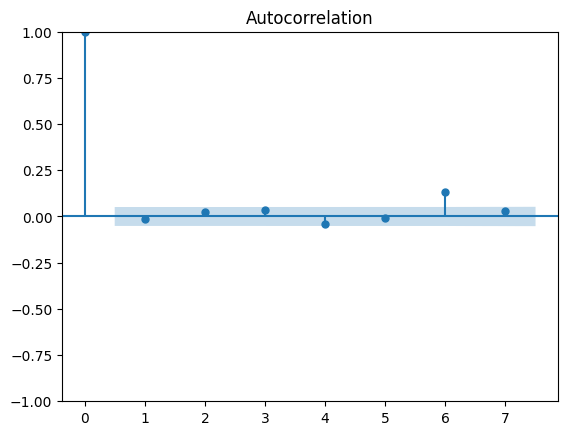

In [35]:
# still some weekly seasonality
plot_acf(residuals, lags=7)

### Need to use robust standard errors

In [36]:
# get best parameters from auto arima model
mod_order = model.order
mod_seasonal_order = model.seasonal_order

In [37]:
# sm_model = sm.tsa.arima.model.ARIMA(ts_data, order=(p, d, q))
# sm_results = sm_model.fit(cov_type='robust')
sm_model = SARIMAX(report_counts_sens, 
                 exog= np.column_stack([step, ramp]),
                 order=mod_order, 
                 seasonal_order=mod_seasonal_order)
sm_results = sm_model.fit(cov_type='robust')

/Users/gabriellelow/anaconda3/envs/css/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/gabriellelow/anaconda3/envs/css/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/gabriellelow/anaconda3/envs/css/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [38]:
# x1 = step
# x2 = ramp
# both the step and the ramp are statistically significant
sm_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                      n   No. Observations:                 1461
Model:             SARIMAX(1, 1, 1)x(0, 0, [1, 2], 7)   Log Likelihood               -7179.611
Date:                                Wed, 21 Jan 2026   AIC                          14373.221
Time:                                        10:08:02   BIC                          14410.224
Sample:                                    08-01-2021   HQIC                         14387.025
                                         - 07-31-2025                                         
Covariance Type:                               robust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            36.0143     15.422      2.335      0.020       5.787      66.241
x2            -0.1567      0.112     -1.394      0.163      -0.377       0.064
ar.L1          0.4344      0.064      6.830      0.000       0.310       0.559
ma.L1         -0.9682      0.010    -94.587      0.000      -0.988      -0.948
ma.S.L7        0.2087      0.048      4.327      0.000       0.114       0.303
ma.S.L14       0.2112      0.031      6.867      0.000       0.151       0.271
sigma2      1092.0734    190.224      5.741      0.000     719.241    1464.906
===================================================================================
Ljung-Box (L1) (Q):                   0.36   Jarque-Bera (JB):            110028.14
Prob(Q):                              0.55   Prob(JB):                         0.00
Heteroskedasticity (H):               2.04   Skew:                             2.73
Prob(H) (two-sided):                  0.00   Kurtosis:                        45.18
===================================================================================

Warnings:
[1] Quasi-maximum likelihood covariance matrix used for robustness to some misspecifications; calculated using the observed information matrix (complex-step) described in Harvey (1989).
"""

Both the step and the ramp are statistically significant.

Interpretation: 
* When the Safe Sleeping Ordinance was passed, the number of reports in sensitive areas increased by a "step" of 124 reports.
* For each day after the Safe Sleeping Ordinace was passed, the number of reports decrease by 0.5, on average. 

We have heteroskedasticity (non-seasonal), but our robust standard errors should correct inference for heteroskedasticity. 



In [39]:
# significant evidence of heteroskedasticity
sm_results.test_heteroskedasticity(method='breakvar')

array([[2.04231124e+00, 6.49893623e-15]])

In [40]:
sm_results.conf_int()

,0,1
x1,5.787283,66.241372
x2,-0.377144,0.063646
ar.L1,0.309769,0.559114
ma.L1,-0.988261,-0.948136
ma.S.L7,0.114148,0.303222
ma.S.L14,0.150895,0.271441
sigma2,719.241053,1464.905764


## Counteractual estimation using parameters from pre-ordinance TS

In [41]:
pre_ord_reports = report_counts_sens[report_counts_sens.index < ord_date]

In [42]:
# we use the same parameters as before, since we had controlled for the intervention

model2 = pm.auto_arima(pre_ord_reports['n'], 
                             seasonal=True, 
                             m=7, 
                             stepwise=True)



In [43]:
mod2_order = model2.order
mod2_seasonal_order = model2.seasonal_order
print(mod2_order)
print(mod2_seasonal_order)

(2, 1, 2)
(2, 0, 2, 7)


In [44]:
sm_model2 = ARIMA(pre_ord_reports,
                 order=mod2_order, 
                 seasonal_order=mod2_seasonal_order)
sm_results2 = sm_model2.fit(cov_type='robust')

sm_results2.summary()

/Users/gabriellelow/anaconda3/envs/css/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/gabriellelow/anaconda3/envs/css/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/gabriellelow/anaconda3/envs/css/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/gabriellelow/anaconda3/envs/css/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/gabriellelow/anaconda3/envs

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    SARIMAX Results                                    
=======================================================================================
Dep. Variable:                               n   No. Observations:                  729
Model:             ARIMA(2, 1, 2)x(2, 0, 2, 7)   Log Likelihood               -3371.573
Date:                         Wed, 21 Jan 2026   AIC                           6761.147
Time:                                 10:09:05   BIC                           6802.460
Sample:                             08-01-2021   HQIC                          6777.088
                                  - 07-30-2023                                         
Covariance Type:                        robust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9111      0.180      5.062      0.000       0.558       1.264
ar.L2         -0.0731      0.107     -0.681      0.496      -0.283       0.137
ma.L1         -1.4403      0.177     -8.138      0.000      -1.787      -1.093
ma.L2          0.4598      0.166      2.763      0.006       0.134       0.786
ar.S.L7        0.1593      0.093      1.713      0.087      -0.023       0.341
ar.S.L14       0.8366      0.092      9.064      0.000       0.656       1.018
ma.S.L7       -0.0331      0.080     -0.413      0.679      -0.190       0.124
ma.S.L14      -0.8408      0.070    -12.085      0.000      -0.977      -0.704
sigma2       605.0474     39.116     15.468      0.000     528.382     681.713
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                52.15
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               2.05   Skew:                             0.45
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.95
===================================================================================

Warnings:
[1] Quasi-maximum likelihood covariance matrix used for robustness to some misspecifications; calculated using the observed information matrix (complex-step) described in Harvey (1989).
"""

In [45]:
pre_ord_reports['n']

date_requested
2021-08-01     67
2021-08-02     96
2021-08-03    121
2021-08-04    101
2021-08-05    107
             ... 
2023-07-26    204
2023-07-27    212
2023-07-28    275
2023-07-29    151
2023-07-30    161
Name: n, Length: 729, dtype: int64

### Forecast post-intervention


In [46]:
fc = sm_results2.get_forecast(steps=731).summary_frame()
fc

n,mean,mean_se,mean_ci_lower,mean_ci_upper
2023-07-31,204.551885,24.597713,156.341253,252.762516
2023-08-01,228.288768,27.186613,175.003986,281.573551
2023-08-02,217.398287,28.711064,161.125636,273.670939
2023-08-03,214.495606,29.816531,156.056278,272.934933
2023-08-04,202.960293,30.657953,142.871809,263.048777
...,...,...,...,...
2025-07-26,341.424148,378.852777,-401.113651,1083.961947
2025-07-27,328.479805,379.453204,-415.234808,1072.194418
2025-07-28,361.378688,380.125545,-383.653689,1106.411065
2025-07-29,380.509151,380.754920,-365.756780,1126.775081


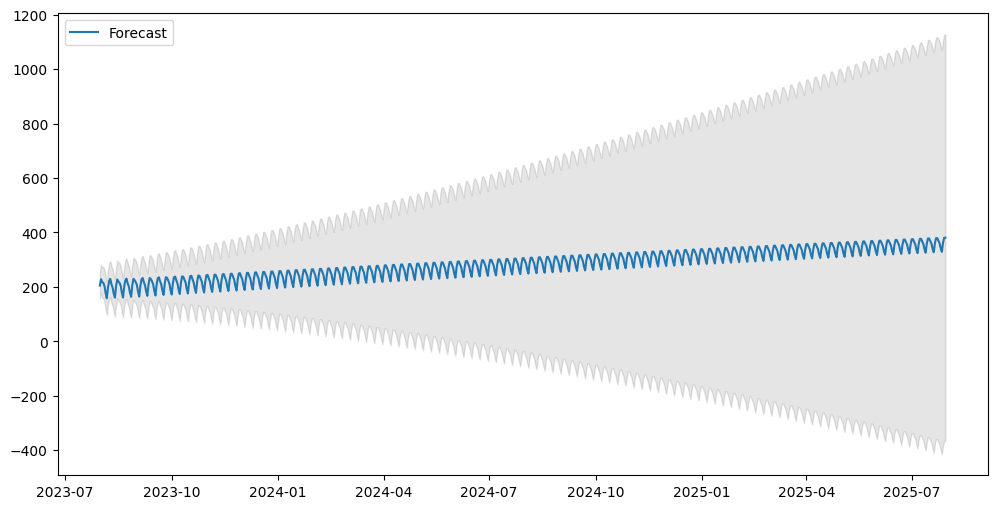

In [47]:
plt.figure(figsize=(12, 6))
plt.plot(fc['mean'], label="Forecast")
plt.fill_between(fc.index, fc['mean_ci_lower'], fc['mean_ci_upper'], color='k', alpha=0.1)
plt.legend()

plt.show()

### Compare with observed data

In [48]:
post_ord_reports = report_counts_sens[report_counts_sens.index >= ord_date]

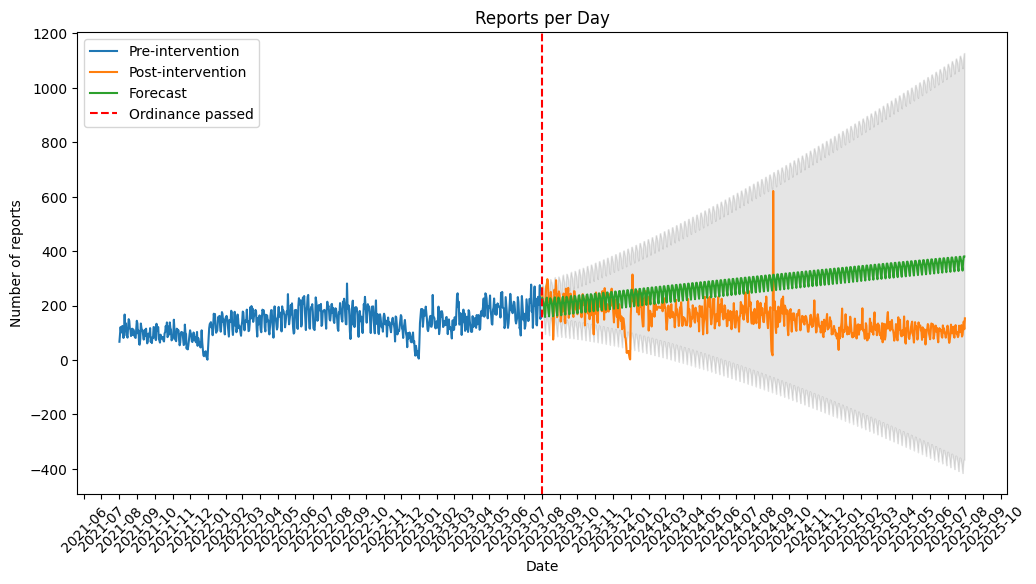

In [49]:
# confidence interval way too big; encompasses all of the observed values

plt.figure(figsize=(12, 6))
plt.plot(pre_ord_reports, label="Pre-intervention")
plt.plot(post_ord_reports, label="Post-intervention")
plt.plot(fc['mean'], label="Forecast")
plt.fill_between(fc.index, fc['mean_ci_lower'], fc['mean_ci_upper'], color='k', alpha=0.1)

plt.axvline(ord_date, color="red", linestyle="--", label = "Ordinance passed")

plt.xlabel("Date")
plt.ylabel("Number of reports")
plt.title("Reports per Day")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.xticks(rotation=45)

plt.legend()

plt.show()

## Reports per type of sensitive area

In [4]:
reports.columns

Index(['service_re', 'sap_notifi', 'date_reque', 'case_age_d', 'case_recor',
       'date_close', 'status', 'lat', 'lng', 'street_add', 'zipcode',
       'council_di', 'comm_plan_', 'comm_pla_1', 'park_name', 'case_origi',
       'referred', 'iamfloc', 'floc', 'public_des', 'Case Numbe', 'Department',
       'Date/Time', 'Status_1', 'Case Reaso', 'Display Re', 'prop_upper',
       'prop_all_c', 'num_exclam', 'num_questi', 'clean_text', 'word_count',
       'clean_te_1', 'misspelled', 'num_misspe', 'year', 'month', 'day',
       'date', 'time', 'time_perio', 'week_type', 'in_transit', 'in_park',
       'in_school_', 'in_open_sp', 'in_waterwa', 'in_open_space',
       'in_waterway'],
      dtype='object')

In [13]:
print("Transit: " + str(round(reports.in_transit.mean(), 4)))
print("Parks: " + str(round(reports.in_park.mean(), 4)))
print("Schools: " + str(round(reports.in_school_.mean(), 4)))
print("Open Spaces: " + str(round(reports.in_open_space.mean(), 4)))
print("Waterways: " + str(round(reports.in_waterway.mean(), 4)))

Transit: 0.7928
Parks: 0.0572
Schools: 0.0002
Open Spaces: 0.0044
Waterways: 0.1083


### Near/in transit

In [21]:
transit_reports = reports[reports.in_transit == 1]
transit_reports.head()

,service_re,sap_notifi,date_reque,case_age_d,case_recor,date_close,status,lat,lng,street_add,...,time,time_perio,week_type,in_transit,in_park,in_school_,in_open_sp,in_waterwa,in_open_space,in_waterway
1,3454993,NaN,2021-08-02,1,Neighborhood Policing,2021-08-03 00:00:00,Closed,32.762736,-117.066252,6106 Adams Ave,...,1,Dark,Weekday,1,0,0,0,0,0,0
2,3454993,NaN,2021-08-02,1,Neighborhood Policing,2021-08-03 00:00:00,Closed,32.762736,-117.066252,6106 Adams Ave,...,1,Dark,Weekday,1,0,0,0,0,0,0
3,3454993,NaN,2021-08-02,1,Neighborhood Policing,2021-08-03 00:00:00,Closed,32.762736,-117.066252,6106 Adams Ave,...,1,Dark,Weekday,1,0,0,0,0,0,0
4,3454993,NaN,2021-08-02,1,Neighborhood Policing,2021-08-03 00:00:00,Closed,32.762736,-117.066252,6106 Adams Ave,...,1,Dark,Weekday,1,0,0,0,0,0,0
5,3457547,NaN,2021-08-04,40,Neighborhood Policing,2021-09-13 00:00:00,Referred,32.788346,-117.254238,3947?3951 Strand Way,...,1,Dark,Weekday,1,0,0,0,0,0,0


Looks like the increasing/decreasing trend in the overall reports are due to transit areas. 

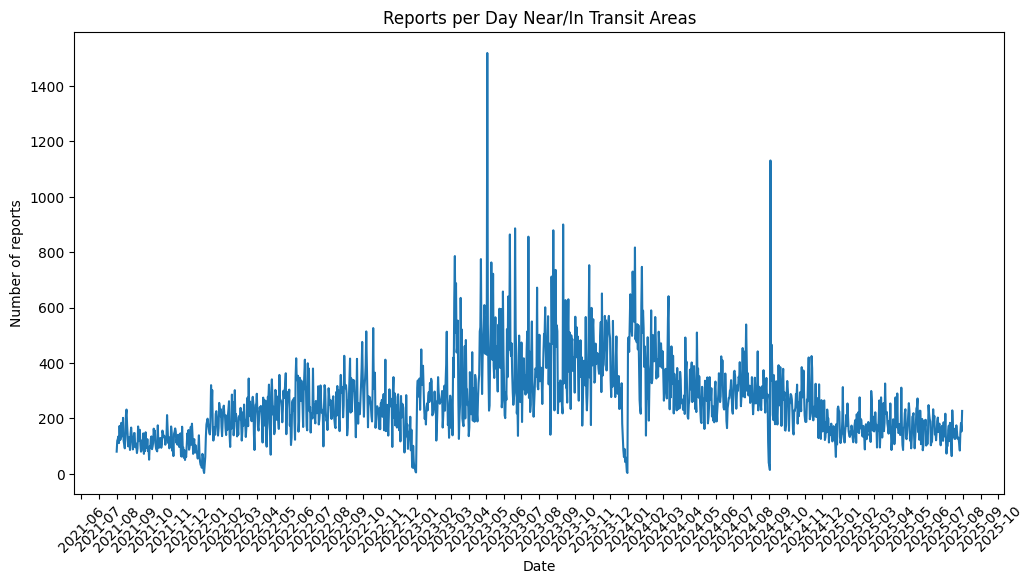

In [ ]:

transit_counts = transit_reports.groupby('date_requested').size().reset_index(name="n")
transit_counts.set_index("date_requested", inplace = True)
plt.figure(figsize=(12, 6))
plt.plot(transit_counts['n'])
plt.xlabel("Date")
plt.ylabel("Number of reports")
plt.title("Reports per Day Near/In Transit Areas")

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.xticks(rotation=45)
plt.show()

### Near/in parks

Yearly seasonality: warmer months associated with more reports, not surprising

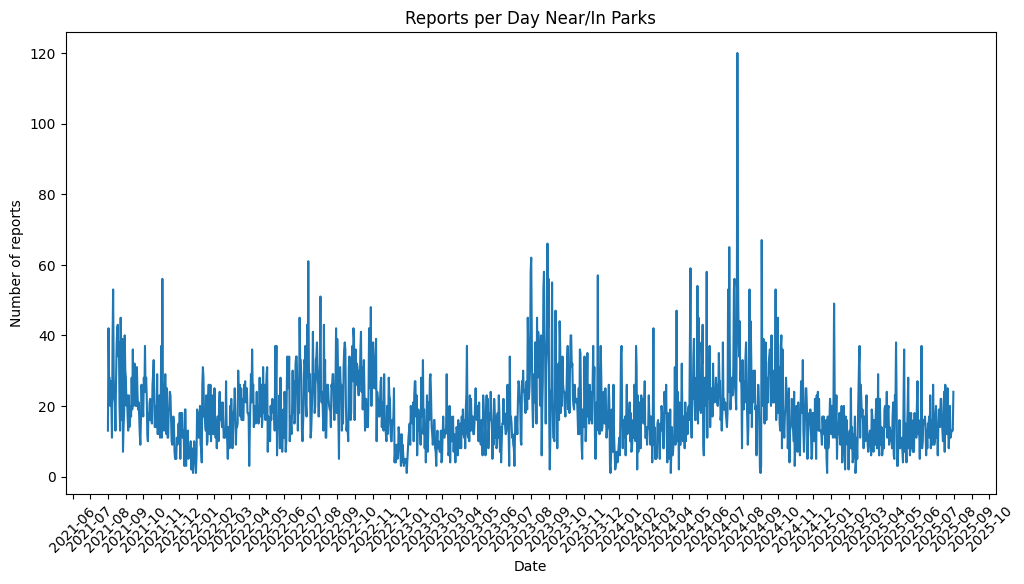

In [ ]:
park_reports = reports[reports.in_park == 1]

park_counts = park_reports.groupby('date_requested').size().reset_index(name="n")
park_counts.set_index("date_requested", inplace = True)
plt.figure(figsize=(12, 6))
plt.plot(park_counts['n'])
plt.xlabel("Date")
plt.ylabel("Number of reports")
plt.title("Reports per Day Near/In Parks")

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.xticks(rotation=45)
plt.show()

### Near/in schools

Not enough data to show any pattern, though looks like there was an incident in June 2023.

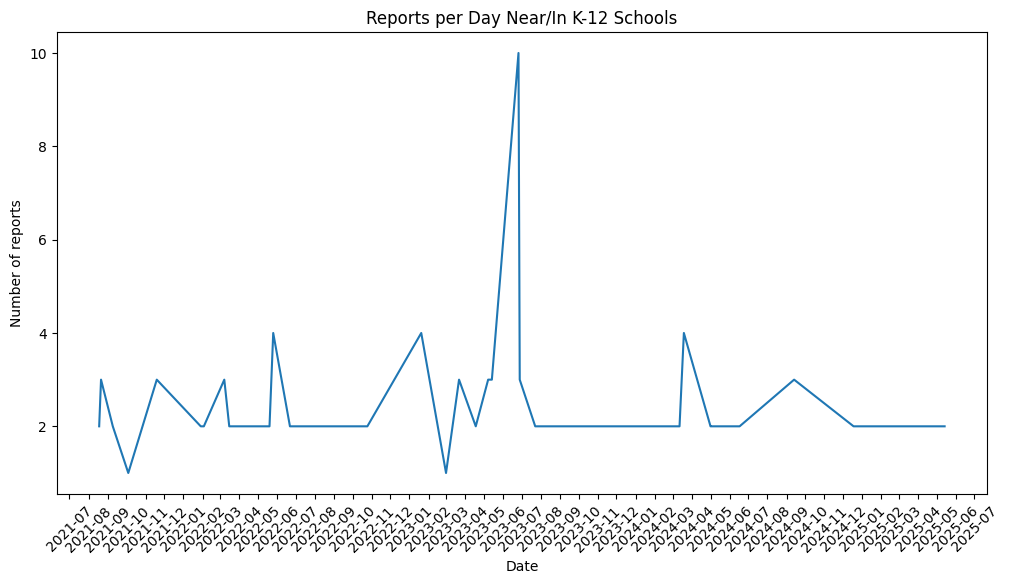

In [ ]:
school_reports = reports[reports.in_school_ == 1]

school_counts = school_reports.groupby('date_requested').size().reset_index(name="n")
school_counts.set_index("date_requested", inplace = True)
plt.figure(figsize=(12, 6))
plt.plot(school_counts['n'])
plt.xlabel("Date")
plt.ylabel("Number of reports")
plt.title("Reports per Day Near/In K-12 Schools")

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.xticks(rotation=45)
plt.show()

### In open spaces

No apparent pattern.

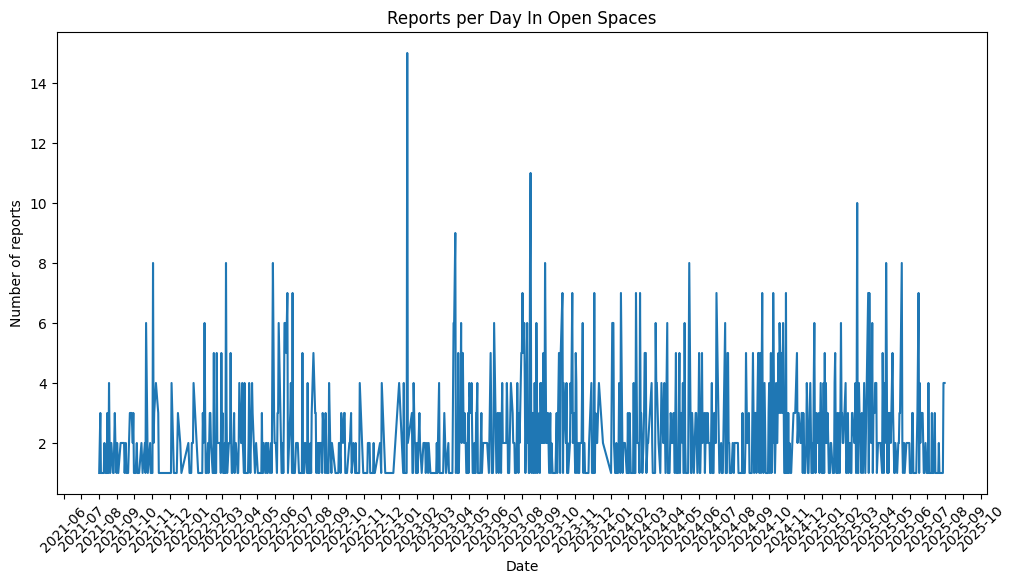

In [ ]:
open_space_reports = reports[reports.in_open_space == 1]

open_space_counts = open_space_reports.groupby('date_requested').size().reset_index(name="n")
open_space_counts.set_index("date_requested", inplace = True)
plt.figure(figsize=(12, 6))
plt.plot(open_space_counts['n'])
plt.xlabel("Date")
plt.ylabel("Number of reports")
plt.title("Reports per Day In Open Spaces")

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.xticks(rotation=45)
plt.show()

### In waterways

Has a similar "increasing then decreasing" pattern as the transit reports

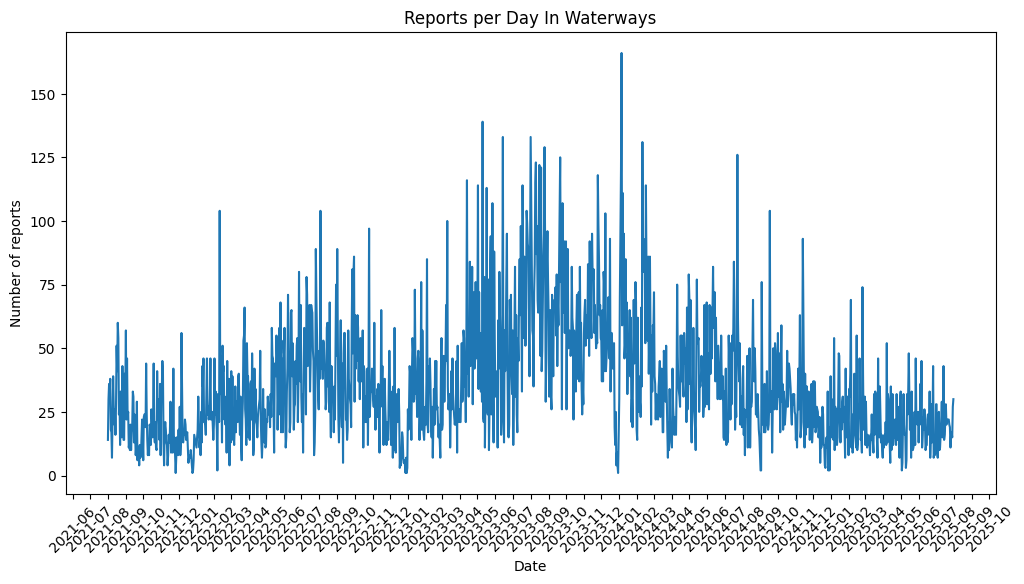

In [ ]:
waterways_reports = reports[reports.in_waterway == 1]

waterways_counts = waterways_reports.groupby('date_requested').size().reset_index(name="n")
waterways_counts.set_index("date_requested", inplace = True)
plt.figure(figsize=(12, 6))
plt.plot(waterways_counts['n'])
plt.xlabel("Date")
plt.ylabel("Number of reports")
plt.title("Reports per Day In Waterways")

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.xticks(rotation=45)
plt.show()

## Look at Downtown Partnership data

In [50]:
dtp = gpd.read_file("other_data/DTP_Jan2014_Dec2024_Final/DTP_Jan2014_Dec2024_Final.shp")
dtp.head()

,FILE_ID,NEIGHBORHO,TYPE,COUNT,MONTH,YEAR,x,y,longitude,latitude,DATE,geometry
0,AWIpGHhttioJR9CUJsH+L0mz0aMWrPdqcfLMEA==,East Village South,Individual,5.0,1.0,2014.0,6.282334e+06,1.837657e+06,-117.158045,32.705409,2014-01-15,POINT (6282334.08 1837657.177)
1,AWIpGHhttioJR9CUJsH+L0mz0aMWrPdqcfLMEA==,East Village South,Individual,3.0,1.0,2014.0,6.282085e+06,1.837839e+06,-117.158861,32.705904,2014-01-15,POINT (6282084.841 1837839.396)
2,AWIpGHhttioJR9CUJsH+L0mz0aMWrPdqcfLMEA==,East Village South,Individual,1.0,1.0,2014.0,6.281976e+06,1.837916e+06,-117.159215,32.706113,2014-01-15,POINT (6281976.356 1837916.365)
3,AWIpGHhttioJR9CUJsH+L0mz0aMWrPdqcfLMEA==,East Village South,Individual,2.0,1.0,2014.0,6.284279e+06,1.837719e+06,-117.151725,32.705626,2014-01-15,POINT (6284279.098 1837719.146)
4,AWIpGHhttioJR9CUJsH+L0mz0aMWrPdqcfLMEA==,East Village South,Individual,2.0,1.0,2014.0,6.284486e+06,1.838048e+06,-117.151062,32.706535,2014-01-15,POINT (6284485.697 1838048.191)


In [ ]:
# from 2014 to 2024, monthly data
dtp.DATE.unique()

<DatetimeArray>
['2014-01-15 00:00:00', '2014-02-15 00:00:00', '2014-03-15 00:00:00',
 '2014-04-15 00:00:00', '2014-05-15 00:00:00', '2014-06-15 00:00:00',
 '2014-07-15 00:00:00', '2014-10-15 00:00:00', '2014-11-15 00:00:00',
 '2014-12-15 00:00:00',
 ...
 '2024-05-15 00:00:00', '2018-11-15 00:00:00', '2019-12-15 00:00:00',
 '2024-06-15 00:00:00', '2024-07-15 00:00:00', '2024-08-15 00:00:00',
 '2024-09-15 00:00:00', '2024-10-15 00:00:00', '2024-11-15 00:00:00',
 '2024-12-15 00:00:00']
Length: 129, dtype: datetime64[ms]

In [54]:
dtp_counts = dtp.groupby("DATE").size().reset_index(name='n')
dtp_counts.set_index("DATE", inplace=True)
dtp_counts.head()

,n
DATE,
2014-01-15,144
2014-02-15,195
2014-03-15,235
2014-04-15,187
2014-05-15,167


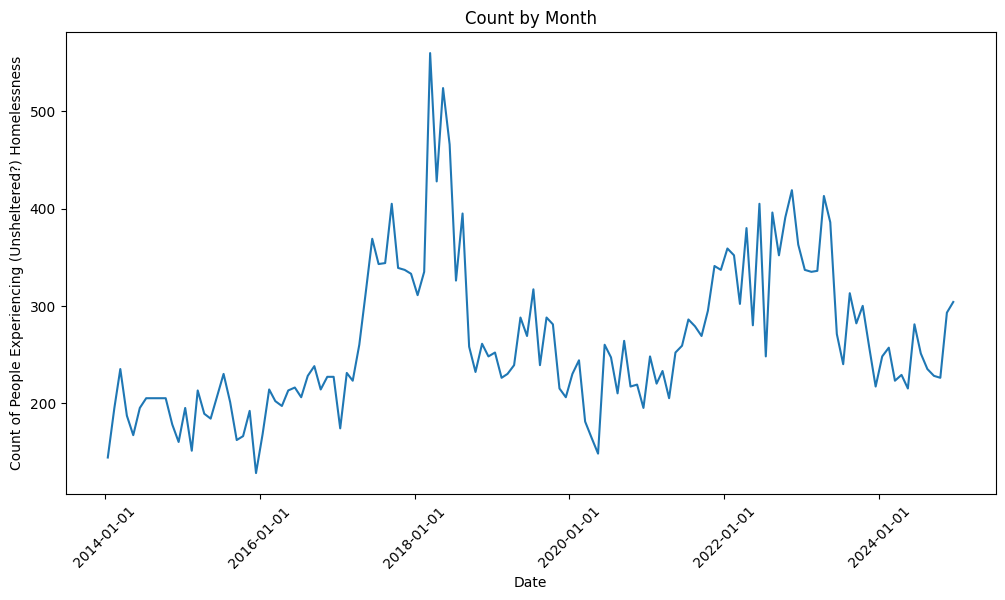

In [55]:
plt.figure(figsize=(12,6))
plt.plot(dtp_counts['n'])
plt.xlabel("Date")
plt.ylabel("Count of People Experiencing (Unsheltered?) Homelessness")
plt.title("Count by Month")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
plt.xticks(rotation=45)
plt.show()

Filter to those in the time range with 311 reports

In [57]:
print(max(reports.date_requested))
print(min(reports.date_requested))

2025-07-31 00:00:00
2021-08-01 00:00:00


In [59]:
dtp_subset = dtp[(dtp['DATE'] >= '2021-08-01') & (dtp['DATE'] <= '2025-07-31')]
dtp_subset.tail()

,FILE_ID,NEIGHBORHO,TYPE,COUNT,MONTH,YEAR,x,y,longitude,latitude,DATE,geometry
34219,gx6dG67KLk1TQ1vGpmu5yXt6sVpyUdyqKwddfg==,Golden Hill,Structure,18.0,12.0,2024.0,6285710.401,1842340.001,-117.147213,32.718364,2024-12-15,POINT (6285710.401 1842340.001)
34220,gx6dG67KLk1TQ1vGpmu5yXt6sVpyUdyqKwddfg==,Golden Hill,Structure,2.0,12.0,2024.0,6285399.761,1842257.800,-117.148221,32.718131,2024-12-15,POINT (6285399.761 1842257.8)
34221,gx6dG67KLk1TQ1vGpmu5yXt6sVpyUdyqKwddfg==,Golden Hill,Structure,1.0,12.0,2024.0,6285479.162,1841820.116,-117.147950,32.716930,2024-12-15,POINT (6285479.162 1841820.116)
34222,gx6dG67KLk1TQ1vGpmu5yXt6sVpyUdyqKwddfg==,Golden Hill,Structure,8.0,12.0,2024.0,6285766.432,1841542.970,-117.147008,32.716175,2024-12-15,POINT (6285766.432 1841542.97)
34223,gx6dG67KLk1TQ1vGpmu5yXt6sVpyUdyqKwddfg==,Golden Hill,Structure,1.0,12.0,2024.0,6285767.477,1841268.029,-117.146997,32.715419,2024-12-15,POINT (6285767.477 1841268.029)


In [167]:
reports_by_month = report_counts_sens.resample("M").mean()
reports_by_month.head()

/var/folders/rz/h3gzrv2j09s6d_5vmn0bglw40000gn/T/ipykernel_24497/2483035925.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  reports_by_month = report_counts_sens.resample("M").mean()


,n
date_requested,
2021-08-31,107.580645
2021-09-30,93.400000
2021-10-31,95.838710
2021-11-30,85.000000
2021-12-31,60.709677


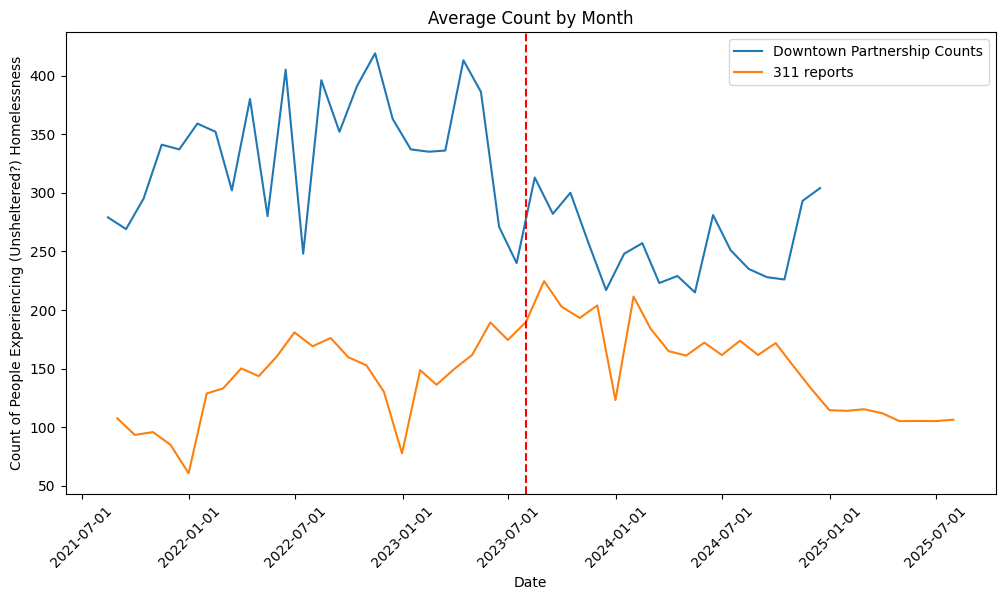

In [73]:
dtp_subset_counts = dtp_subset.groupby('DATE').size().reset_index(name='n')
dtp_subset_counts.set_index("DATE", inplace=True)
plt.figure(figsize=(12, 6))
plt.plot(dtp_subset_counts['n'], label= "Downtown Partnership Counts")
plt.plot(reports_by_month['n'], label= "311 reports")
plt.xlabel('Date')
plt.ylabel("Count of People Experiencing (Unsheltered?) Homelessness")
plt.title("Average Count by Month")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
plt.legend()
plt.xticks(rotation=45)


plt.axvline(ord_date, color="red", linestyle="--", label = "Ordinance passed")
plt.show()


## Robustness Check: Segemented Regression

In [72]:
reports_by_week = report_counts_sens.resample("w").mean()
reports_by_week.head()

/var/folders/rz/h3gzrv2j09s6d_5vmn0bglw40000gn/T/ipykernel_24497/268686364.py:1: FutureWarning: 'w' is deprecated and will be removed in a future version, please use 'W' instead.
  reports_by_week = report_counts_sens.resample("w").mean()


,n
date_requested,
2021-08-01,67.000000
2021-08-08,105.428571
2021-08-15,110.285714
2021-08-22,118.571429
2021-08-29,96.285714


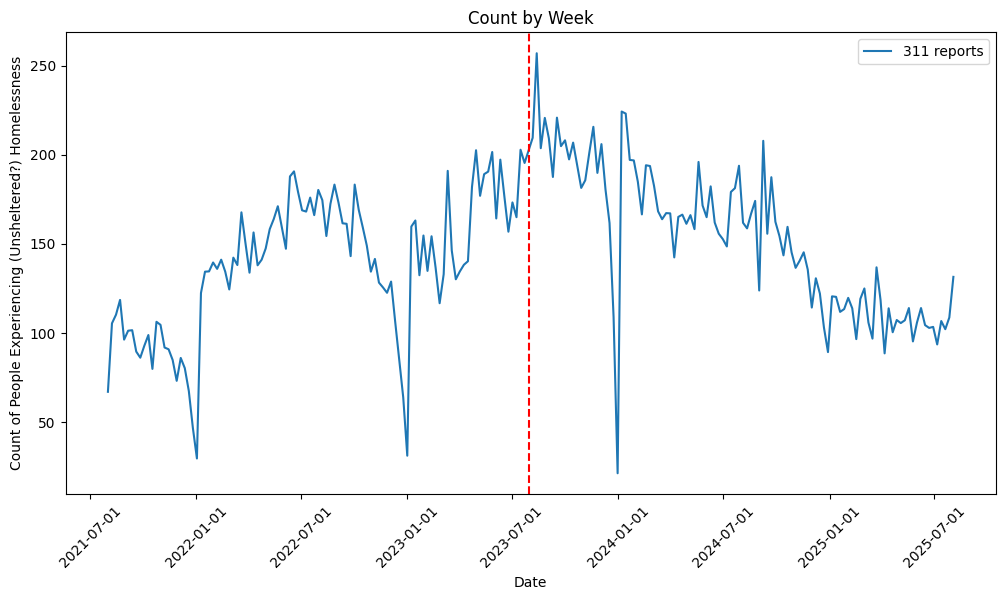

In [74]:
plt.figure(figsize=(12, 6))
plt.plot(reports_by_week['n'], label= "311 reports")
plt.xlabel('Date')
plt.ylabel("Count of People Experiencing (Unsheltered?) Homelessness")
plt.title("Count by Week")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
plt.legend()
plt.xticks(rotation=45)


plt.axvline(ord_date, color="red", linestyle="--", label = "Ordinance passed")
plt.show()


In [76]:
reports_sens.head()

,field_1,service_request_id,sap_notification_number,date_requested,case_age_days,case_record_type,date_closed,status,lat,lng,...,time,time_period,week_type,geometry,in_transit_area,in_park,in_school_area,in_open_space,in_waterway,in_sens_area
0,0,3454060,,2021-08-01,12,Neighborhood Policing,2021-08-12 00:00:00,Closed,32.6966108,-117.1148684,...,1,Dark,Weekend,POINT (6295589.279646916 1834343.227680732),0,0,0,0,0,1
1,1,3454993,,2021-08-02,1,Neighborhood Policing,2021-08-03 00:00:00,Closed,32.7627358263844,-117.0662518,...,1,Dark,Weekday,POINT (6310734.245923505 1858281.285759502),1,0,0,0,0,1
2,2,3457547,,2021-08-04,40,Neighborhood Policing,2021-09-13 00:00:00,Referred,32.7883457662006,-117.2542375,...,1,Dark,Weekday,POINT (6253034.980425371 1868103.4531590594),1,0,0,0,0,1
3,3,3456172,,2021-08-03,30,ESD Complaint/Report,2021-09-02 00:00:00,Closed,32.7526659110063,-117.1465159,...,1,Dark,Weekday,POINT (6286028.505116988 1854820.183631435),1,0,0,0,0,1
4,4,3457550,,2021-08-04,19,ESD Complaint/Report,2021-08-23 00:00:00,Closed,32.7460031444519,-117.1599057,...,1,Dark,Weekday,POINT (6281890.694429106 1852431.7130724536),1,0,0,0,0,1


In [168]:
start_date = min(reports['date_requested'])
reports["ordinance"] = np.where(reports['date_requested'] > ord_date, 1, 0)
reports["num_weeks_after_ord"] = np.where(
    reports['date_requested'] > ord_date, 
    ((reports['date_requested'] - ord_date) / pd.Timedelta(days=7)).astype(int), 
    0
)
reports['week_num'] = ((reports['date_requested'] - start_date )/ pd.Timedelta(days=7)).astype(int)
reports['year'] = reports['date_requested'].dt.year
reports

,field_1,service_request_id,sap_notification_number,date_requested,case_age_days,case_record_type,date_closed,status,lat,lng,...,geometry,in_transit_area,in_park,in_school_area,in_open_space,in_waterway,in_sens_area,ordinance,num_weeks_after_ord,week_num
0,0,3454060,,2021-08-01,12,Neighborhood Policing,2021-08-12 00:00:00,Closed,32.6966108,-117.1148684,...,POINT (6295589.279646916 1834343.227680732),0,0,0,0,0,1,0,0,0
1,1,3454993,,2021-08-02,1,Neighborhood Policing,2021-08-03 00:00:00,Closed,32.7627358263844,-117.0662518,...,POINT (6310734.245923505 1858281.285759502),1,0,0,0,0,1,0,0,0
2,2,3457547,,2021-08-04,40,Neighborhood Policing,2021-09-13 00:00:00,Referred,32.7883457662006,-117.2542375,...,POINT (6253034.980425371 1868103.4531590594),1,0,0,0,0,1,0,0,0
3,3,3456172,,2021-08-03,30,ESD Complaint/Report,2021-09-02 00:00:00,Closed,32.7526659110063,-117.1465159,...,POINT (6286028.505116988 1854820.183631435),1,0,0,0,0,1,0,0,0
4,4,3457550,,2021-08-04,19,ESD Complaint/Report,2021-08-23 00:00:00,Closed,32.7460031444519,-117.1599057,...,POINT (6281890.694429106 1852431.7130724536),1,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213944,213944,5261882,,2025-06-20,136,Neighborhood Policing,11/3/2025,Closed,32.706479533510205,-117.1199069,...,POINT (6294069.174939836 1837946.7068753957),1,0,0,0,1,1,1,98,202
213945,213945,5109198,,2025-02-13,266,Neighborhood Policing,11/6/2025,Closed,32.69738055615184,-117.1364053,...,POINT (6288965.975500593 1834678.9357738034),0,0,0,0,0,1,1,80,184
213946,213946,5121852,,2025-02-24,255,Neighborhood Policing,11/6/2025,Closed,32.7286713,-117.0653949,...,POINT (6310900.742410863 1845885.341907829),0,0,0,0,1,1,1,82,186
213947,213947,5169378,,2025-04-02,218,Neighborhood Policing,11/6/2025,Closed,32.79619964702752,-117.2096772,...,POINT (6266755.575511668 1870831.9638023193),0,0,0,0,1,1,1,87,191


In [131]:
reports.columns

Index(['field_1', 'service_request_id', 'sap_notification_number',
       'date_requested', 'case_age_days', 'case_record_type', 'date_closed',
       'status', 'lat', 'lng', 'street_address', 'zipcode', 'council_district',
       'comm_plan_code', 'comm_plan_name', 'park_name', 'case_origin',
       'referred', 'iamfloc', 'floc', 'public_description', 'Case Number',
       'Department', 'Date/Time Opened', 'Case Reason',
       'Display Referral Information', 'prop_uppercase', 'prop_all_caps',
       'num_exclamation', 'num_question', 'clean_text', 'word_count',
       'clean_text_for_sentiment', 'misspelled_words', 'num_misspelled',
       'year', 'month', 'day', 'date', 'time', 'time_period', 'week_type',
       'geometry', 'in_transit_area', 'in_park', 'in_school_area',
       'in_open_space', 'in_waterway', 'in_sens_area', 'ordinance',
       'num_weeks_after_ord', 'week_num'],
      dtype='object')

In [169]:
offset = min(reports['date_requested']) - pd.to_datetime(ord_date)
reports_ind = reports.set_index("date_requested")
reports_ind = reports_ind.astype({'in_transit_area': "int64",
                                  'in_park': "int64",
                                  'in_school_area': "int64",
                                  'in_open_space': "int64",
                                  'in_waterway': "int64",
                                  'in_sens_area': "int64"})
reports_weekly = reports_ind.groupby(pd.Grouper(freq="W", offset = offset)).agg({
    'in_transit_area': 'mean',
    'in_park': 'mean',
    'in_school_area': 'mean',
    'in_open_space': 'mean',
    'in_waterway': 'mean',
    'in_sens_area': 'mean',
    'num_weeks_after_ord': 'first',
    'week_num': 'first',
    'ordinance': 'first',
    'year': 'first'


})

In [170]:
reports_weekly[reports_weekly['num_weeks_after_ord'] == 1]

,in_transit_area,in_park,in_school_area,in_open_space,in_waterway,in_sens_area,num_weeks_after_ord,week_num,ordinance,year
date_requested,,,,,,,,,,
2023-08-13,0.519733,0.090606,0.0,0.00945,0.166203,1.0,1,105,1,2023


In [172]:
reports_weekly['num_reports'] = reports_ind.groupby(pd.Grouper(freq="W", offset=offset)).size()
reports_weekly

,in_transit_area,in_park,in_school_area,in_open_space,in_waterway,in_sens_area,num_weeks_after_ord,week_num,ordinance,year,num_reports
date_requested,,,,,,,,,,,
2021-08-01,0.447761,0.179104,0.00000,0.014925,0.104478,1.0,0,0,0,2021,67
2021-08-08,0.472900,0.155827,0.00000,0.008130,0.146341,1.0,0,0,0,2021,738
2021-08-15,0.430052,0.199482,0.00000,0.011658,0.155440,1.0,0,1,0,2021,772
2021-08-22,0.472289,0.219277,0.00241,0.013253,0.163855,1.0,0,2,0,2021,830
2021-08-29,0.465875,0.179525,0.00000,0.011869,0.142433,1.0,0,3,0,2021,674
...,...,...,...,...,...,...,...,...,...,...,...
2025-07-06,0.500763,0.120611,0.00000,0.010687,0.128244,1.0,100,204,1,2025,655
2025-07-13,0.468541,0.124498,0.00000,0.009371,0.119143,1.0,101,205,1,2025,747
2025-07-20,0.506294,0.128671,0.00000,0.011189,0.141259,1.0,102,206,1,2025,715


In [ ]:
seg_reg = smf.ols(formula = 'num_reports ~ week_num + ordinance + num_weeks_after_ord + year + in_transit_area + in_park + in_school_area + in_open_space + in_waterway', 
                  data = reports_weekly).fit()
# heteroskedasticity and autocorrelation robust standard errors: yearly seasonality
seg_reg_robust_results = seg_reg.get_robustcov_results(cov_type='HAC',maxlags = 52)
seg_reg_robust_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            num_reports   R-squared:                       0.571
Model:                            OLS   Adj. R-squared:                  0.551
Method:                 Least Squares   F-statistic:                     76.79
Date:                Mon, 26 Jan 2026   Prob (F-statistic):           4.95e-60
Time:                        17:02:54   Log-Likelihood:                -1401.7
No. Observations:                 210   AIC:                             2823.
Df Residuals:                     200   BIC:                             2857.
Df Model:                           9                                         
Covariance Type:                  HAC                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept           -4.875e+05   1.65e+05     -2.956      0.003   -8.13e+05   -1.62e+05
week_num                1.0217      2.029      0.504      0.615      -2.979       5.022
ordinance             236.6120     87.590      2.701      0.007      63.893     409.331
num_weeks_after_ord   -13.7416      0.909    -15.122      0.000     -15.533     -11.950
year                  241.4371     81.615      2.958      0.003      80.500     402.374
in_transit_area       124.5557    404.592      0.308      0.759    -673.258     922.370
in_park               733.5927    884.992      0.829      0.408   -1011.520    2478.705
in_school_area       6746.0375   1.94e+04      0.347      0.729   -3.16e+04    4.51e+04
in_open_space         297.0022   3690.752      0.080      0.936   -6980.777    7574.782
in_waterway           691.3940    446.876      1.547      0.123    -189.799    1572.587
==============================================================================
Omnibus:                       71.909   Durbin-Watson:                   0.870
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              289.524
Skew:                          -1.314   Prob(JB):                     1.35e-63
Kurtosis:                       8.117   Cond. No.                     1.62e+07
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 52 lags and without small sample correction
[2] The condition number is large, 1.62e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

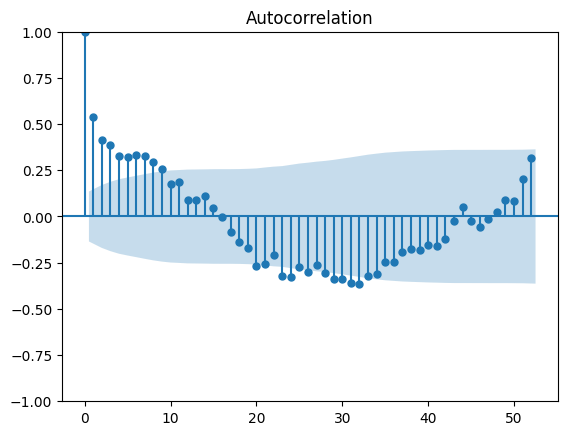

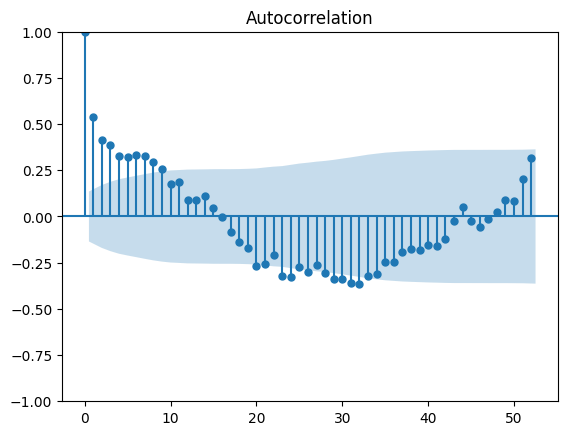

In [176]:
seg_reg_resids = seg_reg.resid

plot_acf(seg_reg_resids, lags= 52)

## SARIMA aggregated by week

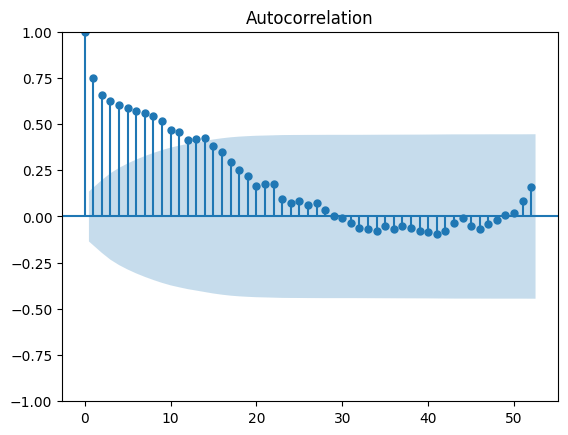

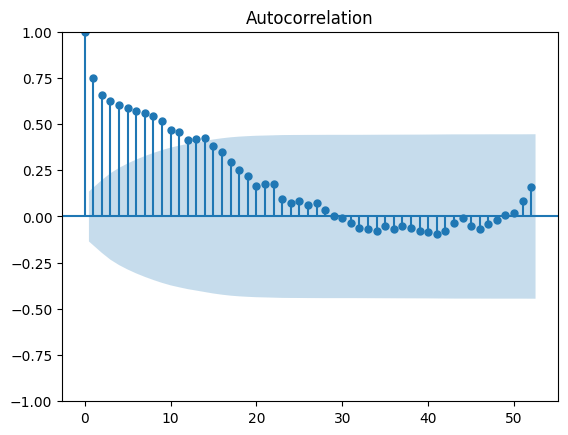

In [151]:
plot_acf(reports_weekly['num_reports'], lags=52)

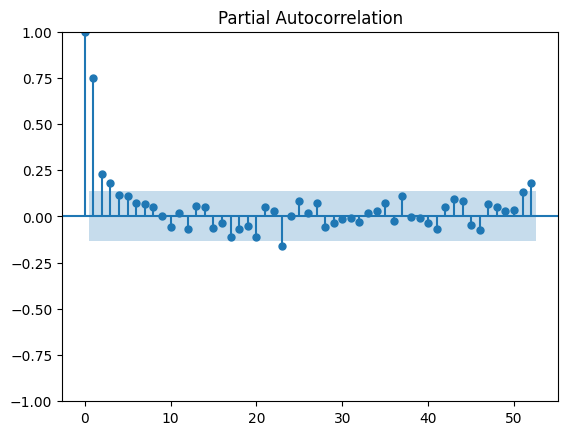

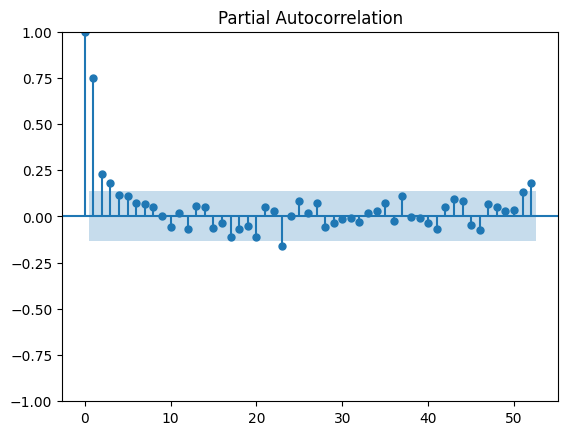

In [152]:
plot_pacf(reports_weekly['num_reports'], lags=52)

In [145]:

sarima_week = pm.auto_arima(reports_weekly['num_reports'], 
                             exogenous= [['ordinance', 'num_weeks_after_ord', 'in_transit_area', 
             'in_park', 'in_school_area', 'in_open_space', 
             'in_waterway']],
                             seasonal=True,  
                             m=52,
    stepwise=True,
    max_P=2,  
    max_Q=2,  
    suppress_warnings=True,
    error_action='ignore')
sarima_week.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  210
Model:             SARIMAX(0, 1, 2)x(1, 0, [], 52)   Log Likelihood               -1359.609
Date:                             Fri, 23 Jan 2026   AIC                           2727.219
Time:                                     22:51:35   BIC                           2740.588
Sample:                                 08-01-2021   HQIC                          2732.624
                                      - 08-03-2025                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5336      0.041    -13.137      0.000      -0.613      -0.454
ma.L2         -0.1571      0.065     -2.428      0.015      -0.284      -0.030
ar.S.L52       0.4078      0.046      8.814      0.000       0.317       0.499
sigma2      2.494e+04   1836.233     13.582      0.000    2.13e+04    2.85e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.19   Jarque-Bera (JB):               111.75
Prob(Q):                              0.66   Prob(JB):                         0.00
Heteroskedasticity (H):               0.79   Skew:                             0.36
Prob(H) (two-sided):                  0.32   Kurtosis:                         6.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

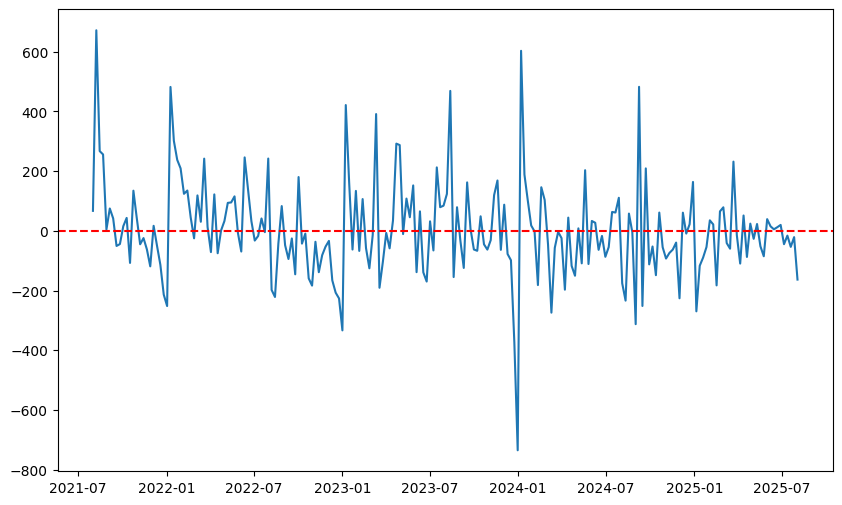

In [ ]:
# check residuals
residuals = sarima_week.resid()

# plot
# we still see some heteroskedasticity 
plt.figure(figsize=(10,6))
plt.plot(residuals)
plt.axhline(0, color="red", linestyle="--")

In [158]:
week_order = sarima_week.order
seasonal_order = sarima_week.seasonal_order

sm_sarima_week = ARIMA(reports_weekly['num_reports'],
                 exog=reports_weekly[['ordinance', 'num_weeks_after_ord', 'in_transit_area', 
             'in_park', 'in_school_area', 'in_open_space', 
             'in_waterway']],
                 order=week_order, 
                 seasonal_order=seasonal_order).fit(cov_type='robust')
sm_sarima_week.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                       num_reports   No. Observations:                  210
Model:             ARIMA(0, 1, 2)x(1, 0, [], 52)   Log Likelihood               -1351.132
Date:                           Fri, 23 Jan 2026   AIC                           2724.263
Time:                                   22:58:31   BIC                           2761.029
Sample:                               08-01-2021   HQIC                          2739.128
                                    - 08-03-2025                                         
Covariance Type:                          robust                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
ordinance             281.4682    121.431      2.318      0.020      43.467     519.469
num_weeks_after_ord    -7.9189      5.941     -1.333      0.183     -19.562       3.724
in_transit_area      1153.9095    392.741      2.938      0.003     384.151    1923.668
in_park             -1708.5694    706.336     -2.419      0.016   -3092.963    -324.176
in_school_area       1554.0253   1.39e+04      0.112      0.911   -2.57e+04    2.88e+04
in_open_space        -543.6180   2639.592     -0.206      0.837   -5717.124    4629.888
in_waterway          1616.8470    687.520      2.352      0.019     269.332    2964.362
ma.L1                  -0.5369      0.107     -5.021      0.000      -0.746      -0.327
ma.L2                  -0.1641      0.085     -1.939      0.053      -0.330       0.002
ar.S.L52                0.4134      0.088      4.703      0.000       0.241       0.586
sigma2               2.298e+04   2642.070      8.698      0.000    1.78e+04    2.82e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.19   Jarque-Bera (JB):                13.25
Prob(Q):                              0.67   Prob(JB):                         0.00
Heteroskedasticity (H):               1.05   Skew:                             0.30
Prob(H) (two-sided):                  0.84   Kurtosis:                         4.08
===================================================================================

Warnings:
[1] Quasi-maximum likelihood covariance matrix used for robustness to some misspecifications; calculated using the observed information matrix (complex-step) described in Harvey (1989).
"""

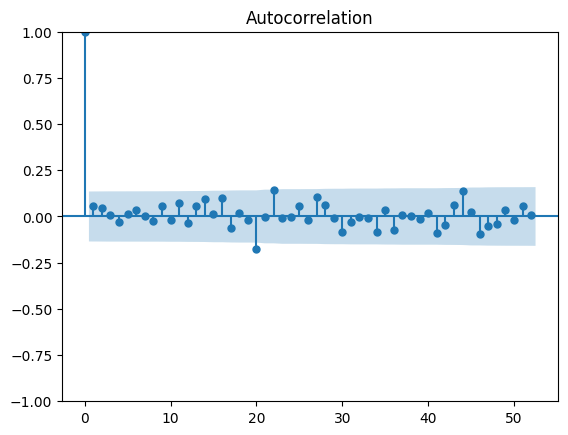

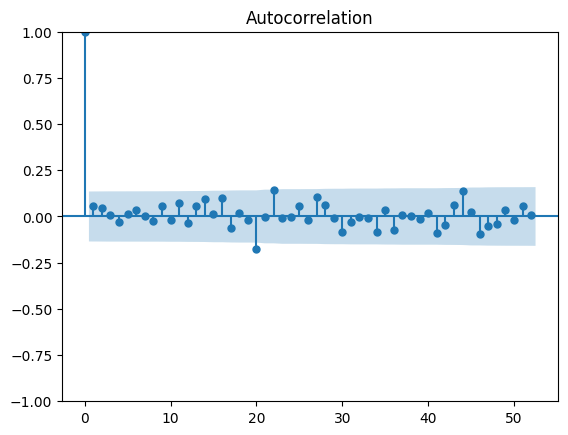

In [160]:
plot_acf(residuals, lags=52)

### Predict the counterfactual

In [193]:
reports_weekly_pre = reports_weekly[reports_weekly.index < ord_date]
sarima_week_pre = pm.auto_arima(reports_weekly_pre['num_reports'], 
                             exogenous= reports_weekly_pre[['in_transit_area', 
             'in_park', 'in_school_area', 'in_open_space', 
             'in_waterway']],
                             seasonal=False,  
                             )
sarima_week_pre.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  105
Model:               SARIMAX(0, 1, 2)   Log Likelihood                -680.388
Date:                Mon, 26 Jan 2026   AIC                           1366.775
Time:                        20:31:37   BIC                           1374.708
Sample:                    08-01-2021   HQIC                          1369.989
                         - 07-30-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3028      0.094     -3.213      0.001      -0.488      -0.118
ma.L2         -0.2625      0.113     -2.331      0.020      -0.483      -0.042
sigma2      2.808e+04   3046.534      9.217      0.000    2.21e+04    3.41e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):                93.97
Prob(Q):                              0.77   Prob(JB):                         0.00
Heteroskedasticity (H):               1.33   Skew:                             1.39
Prob(H) (two-sided):                  0.41   Kurtosis:                         6.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [201]:
week_order = sarima_week_pre.order
seasonal_order = sarima_week_pre.seasonal_order

sm_sarima_week_pre = ARIMA(reports_weekly_pre['num_reports'],
                 # need to input exog if you want to forecast
                 order=week_order, 
                 seasonal_order=seasonal_order).fit(cov_type='robust')
sm_sarima_week_pre.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            num_reports   No. Observations:                  105
Model:                 ARIMA(0, 1, 2)   Log Likelihood                -680.388
Date:                Mon, 26 Jan 2026   AIC                           1366.775
Time:                        20:45:12   BIC                           1374.708
Sample:                    08-01-2021   HQIC                          1369.989
                         - 07-30-2023                                         
Covariance Type:               robust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3028      0.142     -2.132      0.033      -0.581      -0.024
ma.L2         -0.2625      0.095     -2.764      0.006      -0.449      -0.076
sigma2      2.808e+04   6899.875      4.070      0.000    1.46e+04    4.16e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):                93.97
Prob(Q):                              0.77   Prob(JB):                         0.00
Heteroskedasticity (H):               1.33   Skew:                             1.39
Prob(H) (two-sided):                  0.41   Kurtosis:                         6.73
===================================================================================

Warnings:
[1] Quasi-maximum likelihood covariance matrix used for robustness to some misspecifications; calculated using the observed information matrix (complex-step) described in Harvey (1989).
"""

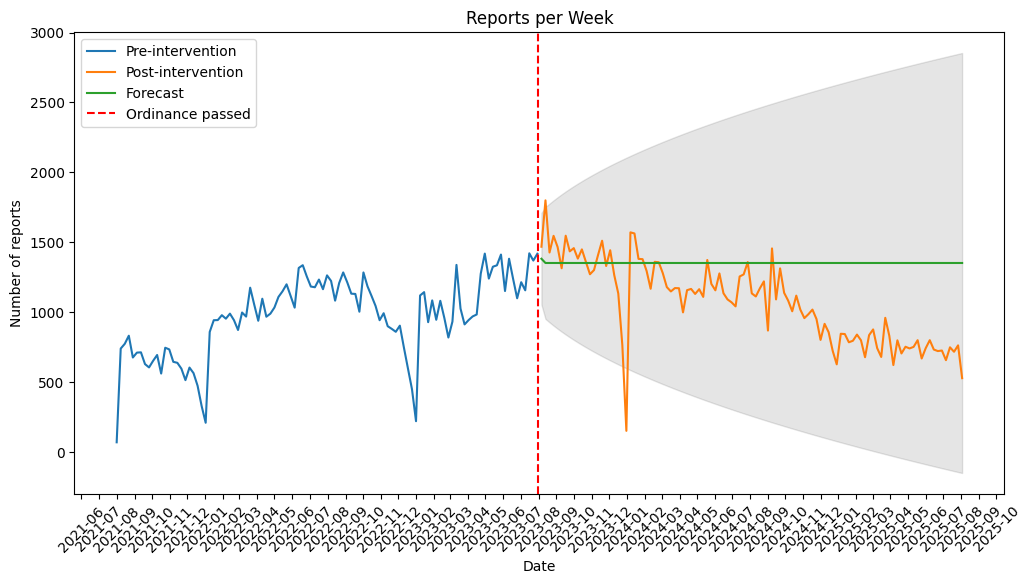

In [203]:
reports_weekly_post = reports_weekly[reports_weekly.index >= ord_date]

fc = sm_sarima_week_pre.get_forecast(steps = 105).summary_frame()


plt.figure(figsize=(12, 6))
plt.plot(reports_weekly_pre['num_reports'], label="Pre-intervention")
plt.plot(reports_weekly_post['num_reports'], label="Post-intervention")
plt.plot(fc['mean'], label="Forecast")
plt.fill_between(fc.index, fc['mean_ci_lower'], fc['mean_ci_upper'], color='k', alpha=0.1)

plt.axvline(ord_date, color="red", linestyle="--", label = "Ordinance passed")

plt.xlabel("Date")
plt.ylabel("Number of reports")
plt.title("Reports per Week")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.xticks(rotation=45)

plt.legend()

plt.show()

In [164]:
# sarima, but aggregated by day
reports_daily = reports_ind.groupby(pd.Grouper(freq="d", offset = offset)).agg({
    'in_transit_area': 'mean',
    'in_park': 'mean',
    'in_school_area': 'mean',
    'in_open_space': 'mean',
    'in_waterway': 'mean',
    'in_sens_area': 'mean',
    'num_weeks_after_ord': 'first',
    'week_num': 'first',
    'ordinance': 'first'


})
reports_daily['num_reports'] = reports_ind.groupby(pd.Grouper(freq="d", offset=offset)).size()

reports_daily.tail()

,in_transit_area,in_park,in_school_area,in_open_space,in_waterway,in_sens_area,num_weeks_after_ord,week_num,ordinance,num_reports
date_requested,,,,,,,,,,
2025-07-27,0.467391,0.108696,0.0,0.000000,0.086957,1.0,103,208,1,92
2025-07-28,0.445378,0.109244,0.0,0.008403,0.126050,1.0,104,208,1,119
2025-07-29,0.524823,0.085106,0.0,0.028369,0.099291,1.0,104,208,1,141
2025-07-30,0.539823,0.097345,0.0,0.035398,0.115044,1.0,104,208,1,113
2025-07-31,0.555556,0.111111,0.0,0.019608,0.104575,1.0,104,208,1,153


In [165]:
sarima_day = pm.auto_arima(reports_daily['num_reports'], 
                             exogenous= [['ordinance', 'num_weeks_after_ord', 'in_transit_area', 
             'in_park', 'in_school_area', 'in_open_space', 
             'in_waterway']],
                             seasonal=True,  
                             m=7,
    stepwise=True,
    )

In [183]:
order = sarima_day.order
seasonal_order = sarima_day.seasonal_order

sm_sarima_day = ARIMA(reports_daily['num_reports'],
                      exog = reports_daily[['ordinance', 'num_weeks_after_ord', 'in_transit_area', 
             'in_park', 'in_school_area', 'in_open_space', 
             'in_waterway']],
             order= order,
             seasonal_order = seasonal_order).fit(cov_type='robust')

sm_sarima_day.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                          num_reports   No. Observations:                 1461
Model:             ARIMA(1, 1, 1)x(0, 0, [1, 2], 7)   Log Likelihood               -7164.979
Date:                              Mon, 26 Jan 2026   AIC                          14353.958
Time:                                      17:19:55   BIC                          14417.392
Sample:                                  08-01-2021   HQIC                         14377.622
                                       - 07-31-2025                                         
Covariance Type:                             robust                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
ordinance              21.9076     14.368      1.525      0.127      -6.254      50.069
num_weeks_after_ord    -0.3019      0.811     -0.372      0.710      -1.892       1.288
in_transit_area        39.5880     16.616      2.382      0.017       7.021      72.155
in_park               -13.0943     17.559     -0.746      0.456     -47.509      21.320
in_school_area        812.8015    485.541      1.674      0.094    -138.842    1764.445
in_open_space        -435.7121    188.226     -2.315      0.021    -804.629     -66.795
in_waterway            16.1183     19.699      0.818      0.413     -22.492      54.728
ar.L1                   0.4431      0.057      7.718      0.000       0.331       0.556
ma.L1                  -0.9656      0.011    -87.182      0.000      -0.987      -0.944
ma.S.L7                 0.2117      0.045      4.751      0.000       0.124       0.299
ma.S.L14                0.2040      0.029      7.019      0.000       0.147       0.261
sigma2               1070.3229    164.236      6.517      0.000     748.426    1392.220
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):             65015.71
Prob(Q):                              0.80   Prob(JB):                         0.00
Heteroskedasticity (H):               1.93   Skew:                             2.25
Prob(H) (two-sided):                  0.00   Kurtosis:                        35.38
===================================================================================

Warnings:
[1] Quasi-maximum likelihood covariance matrix used for robustness to some misspecifications; calculated using the observed information matrix (complex-step) described in Harvey (1989).
"""